In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [2]:
import tensorflow as tf
# import tf-nightly-gpu as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
# tf.debugging.set_log_device_placement(True)
print(tf.__version__)

2.3.1


In [3]:
tf.test.is_built_with_cuda()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.config.experimental.list_physical_devices('GPU')

Num GPUs Available:  1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
TRAIN_COUNT = 10000

In [6]:
# data = pd.read_excel('Simulation.xlsx')
data = pd.read_excel('data.xlsx')

In [7]:
train_dataset = data.sample(frac=0.8, random_state=0)
test_dataset = data.drop(train_dataset.index)

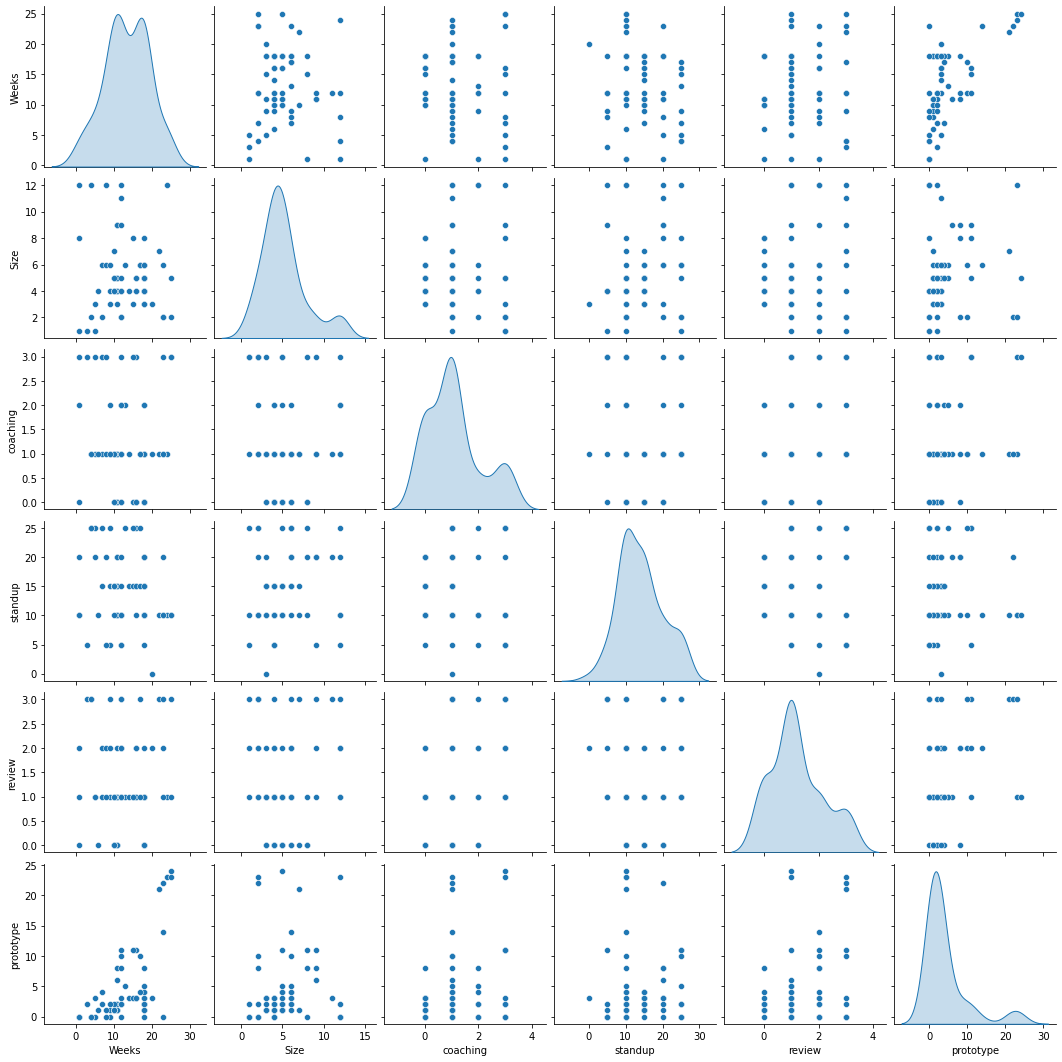

In [8]:
sns.pairplot(train_dataset[['Weeks', 'Size', 'coaching', 'standup', 'review','prototype']], diag_kind='kde')

In [9]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('Result')
test_labels = test_features.pop('Result')

In [10]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
Weeks,13.473684,5.788434
Size,5.118421,2.663167
skill 1,0.355263,0.481773
skill 2,0.197368,0.400657
skill 3,0.171053,0.379057
skill 4,0.276316,0.450146
coaching,1.092105,0.982210
standup,14.013158,5.888958
review,1.210526,0.942561
overtime 1,0.184211,0.390232


In [11]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[13.474  5.118  0.355  0.197  0.171  0.276  1.092 14.013  1.211  0.184
  0.434  0.382  4.184]


In [12]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[18  4  1  0  0  0  1 15  0  0  0  1  2]]

Normalized: [[ 0.79 -0.42  1.35 -0.5  -0.45 -0.62 -0.09  0.17 -1.29 -0.48 -0.88  1.27
  -0.38]]


In [13]:
Size = np.array(train_features['Size'])

Size_normalizer = preprocessing.Normalization(input_shape=[1,])
Size_normalizer.adapt(Size)

In [14]:
Size_model = tf.keras.Sequential([
    Size_normalizer,
    layers.Dense(units=16)
])

Size_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 16)                32        
Total params: 35
Trainable params: 32
Non-trainable params: 3
_________________________________________________________________


In [15]:
Size_model.predict(Size[:10])

array([[-0.189, -0.232,  0.076, -0.12 ,  0.078, -0.238,  0.161,  0.007,
        -0.154,  0.187, -0.238,  0.073, -0.199, -0.117,  0.184,  0.15 ],
       [-0.359, -0.44 ,  0.145, -0.227,  0.149, -0.451,  0.306,  0.012,
        -0.292,  0.354, -0.451,  0.138, -0.376, -0.221,  0.348,  0.285],
       [ 1.166,  1.429, -0.47 ,  0.736, -0.483,  1.465, -0.994, -0.04 ,
         0.95 , -1.15 ,  1.463, -0.447,  1.222,  0.718, -1.129, -0.925],
       [ 0.149,  0.183, -0.06 ,  0.094, -0.062,  0.188, -0.127, -0.005,
         0.122, -0.147,  0.187, -0.057,  0.157,  0.092, -0.145, -0.118],
       [-0.02 , -0.025,  0.008, -0.013,  0.008, -0.025,  0.017,  0.001,
        -0.016,  0.02 , -0.025,  0.008, -0.021, -0.012,  0.019,  0.016],
       [ 0.149,  0.183, -0.06 ,  0.094, -0.062,  0.188, -0.127, -0.005,
         0.122, -0.147,  0.187, -0.057,  0.157,  0.092, -0.145, -0.118],
       [ 0.658,  0.806, -0.265,  0.415, -0.272,  0.827, -0.56 , -0.023,
         0.536, -0.648,  0.825, -0.252,  0.689,  0.405, -0

In [16]:
Size_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    # optimizer=tf.optimizers.Adam(learning_rate=0),
    loss='mean_absolute_error')

In [17]:
class Print(keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs): 
        print (str(epoch)+' / '+str(TRAIN_COUNT), end="\r")

In [18]:
%%time
history = Size_model.fit(
    train_features['Size'], train_labels,
    epochs=TRAIN_COUNT,
    # epochs=1000,
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2,
    callbacks=[Print()]
    )

Wall time: 3min 36s


In [19]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
9995,136.868912,140.374893,9995
9996,136.868088,140.374603,9996
9997,136.867813,140.374863,9997
9998,136.871414,140.375549,9998
9999,136.867889,140.375427,9999


In [20]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 1000])
  plt.xlabel('Epoch')
  plt.ylabel('Error [Result]')
  plt.legend()
  plt.grid(True)

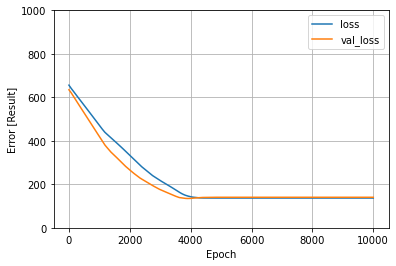

In [21]:
plot_loss(history)

In [22]:
test_results = {}
test_results['Size_model'] = Size_model.evaluate(
    test_features['Size'],
    test_labels, verbose=0)

In [23]:
x = tf.linspace(0.0, 12, 13)
y = Size_model.predict(x)

In [24]:
def plot_Size(x, y):
  plt.scatter(train_features['Size'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Size')
  plt.ylabel('Result')
  plt.legend()

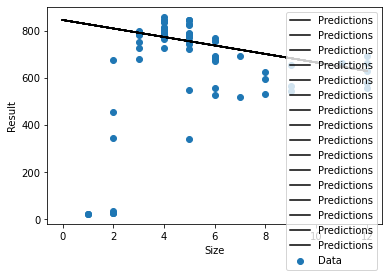

In [25]:
plot_Size(x,y)

In [26]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [27]:
linear_model.predict(train_features[:10])

array([[ 1.086],
       [ 0.237],
       [-1.877],
       [ 1.908],
       [ 0.011],
       [ 0.279],
       [-0.472],
       [-1.047],
       [ 0.848],
       [-1.901]], dtype=float32)

In [28]:
linear_model.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(13, 1) dtype=float32, numpy=
array([[-0.082],
       [-0.068],
       [ 0.614],
       [ 0.406],
       [ 0.21 ],
       [ 0.452],
       [-0.576],
       [ 0.33 ],
       [-0.344],
       [-0.315],
       [-0.35 ],
       [-0.262],
       [-0.507]], dtype=float32)>

In [29]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [30]:
%%time
history = linear_model.fit(
    train_features, train_labels, 
    epochs=TRAIN_COUNT,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2, 
    callbacks=[Print()]
    )

Wall time: 3min 29s


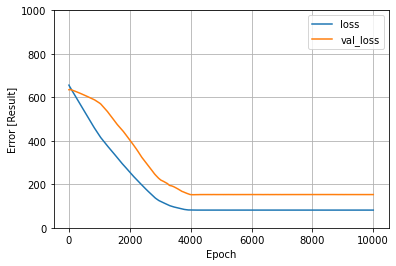

In [31]:
plot_loss(history)

In [32]:

test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

In [48]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(128, activation='relu'),
      layers.Dense(256, activation='relu'),
      layers.Dense(512, activation='relu'),
      layers.Dense(1024, activation='relu'),
      layers.Dense(2048, activation='relu'),
      layers.Dense(1024, activation='relu'),
      layers.Dense(512, activation='relu'),
      layers.Dense(256, activation='relu'),
      layers.Dense(128, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                # optimizer=tf.keras.optimizers.Adam(0.001))
                optimizer=tf.keras.optimizers.Adam(0.00001))
  return model

In [49]:
dnn_Size_model = build_and_compile_model(Size_normalizer)
dnn_Size_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_22 (Dense)             (None, 64)                128       
_________________________________________________________________
dense_23 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_24 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_25 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_26 (Dense)             (None, 1024)              525312    
_________________________________________________________________
dense_27 (Dense)             (None, 2048)             

In [35]:
%%time
history = dnn_Size_model.fit(
    train_features['Size'], train_labels,
    validation_split=0.2,
    # validation_split=0,
    verbose=0, epochs=TRAIN_COUNT, 
    callbacks=[Print()]
    )

Wall time: 3min 48s


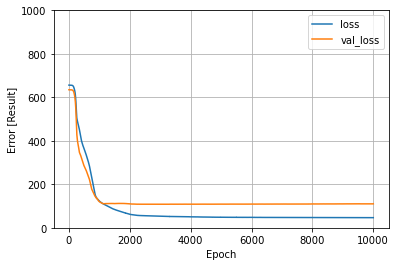

In [36]:
plot_loss(history)

In [37]:
x = tf.linspace(0.0, 12, 13)
y = dnn_Size_model.predict(x)

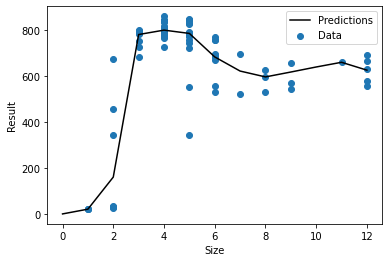

In [38]:
plot_Size(x, y)

In [39]:
test_results['dnn_Size_model'] = dnn_Size_model.evaluate(
    test_features['Size'], test_labels,
    verbose=0)

In [50]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 13)                27        
_________________________________________________________________
dense_34 (Dense)             (None, 64)                896       
_________________________________________________________________
dense_35 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_36 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_37 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_38 (Dense)             (None, 1024)              525312    
_________________________________________________________________
dense_39 (Dense)             (None, 2048)             

In [51]:
%%time
history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=TRAIN_COUNT, 
    callbacks=[Print()]
    )

Wall time: 3min 56s


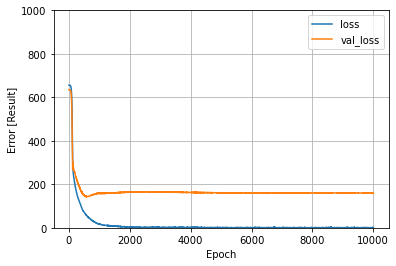

In [52]:
plot_loss(history)

In [53]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [54]:
pd.DataFrame(test_results, index=['Mean absolute error [Result]']).T

,Mean absolute error [Result]
Size_model,133.053558
linear_model,121.340874
dnn_Size_model,107.288513
dnn_model,201.668747


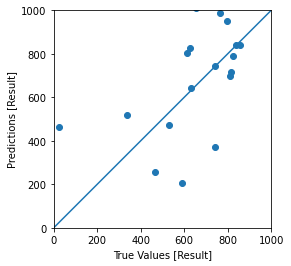

In [55]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Result]')
plt.ylabel('Predictions [Result]')
lims = [0, 1000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

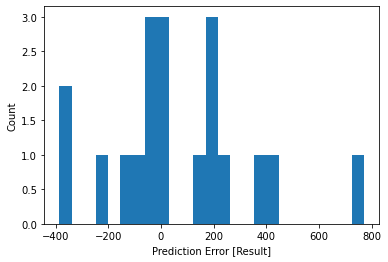

In [56]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [Result]')
_ = plt.ylabel('Count')

In [57]:
dnn_model.save('dnn_model')

INFO:tensorflow:Assets written to: dnn_model\assets
